In [44]:
#Import required modules
import numpy as np
from scipy.interpolate import interp1d
import h5py
import matplotlib.pyplot as plt
from gwosc.datasets import event_gps
import time
%matplotlib inline

First import data from around GW150914 and whiten

In [3]:
def Hann(n, N):
    """Evalute a Hann window of length N at n"""
    y = 0.5*(1-np.cos(2*np.pi*n/(N-1)))
    return y


def calcpsd(x, y, windowl, window):
    """Calculate the PSD from the signal time series averaged from the PSDs of length windowl.
    Use given window to smooth each fft. Return the PSD as an interpolated function.
    Median correction term defined in FINDCHIRP paper."""
    dx = x[1] - x[0]
    neach = int(windowl/dx)
    nfft = int(2 * len(y)//neach - 1)
    shift = int(np.ceil(neach/2))
    freq = np.fft.rfftfreq(neach, dx)
    asds = np.zeros((nfft, len(freq)), dtype='complex')
    psds = np.zeros((nfft, len(freq)), dtype='complex')
    mask = window(np.arange(neach), neach)
    for i in range(0, nfft):
        windowed = y[i*shift:i*shift + neach]*mask
        asds[i, :] = np.fft.rfft(windowed)*dx
        psds[i, :] = 2*(freq[1]-freq[0])*asds[i, :]*np.conj(asds[i, :])/(np.sum(mask**2)/neach)
    if nfft%2 == 0:
        median_correction = 1
    else:
        median_correction = np.sum(np.power(-1.*np.ones(nfft), np.arange(nfft)+2)/(np.arange(nfft)+1))
    psd = np.median(psds, axis=0)/median_correction
    psdi = interp1d(freq, np.real(psd), axis=0, bounds_error=False, fill_value=0)
    return psdi


def whiten(x, y, psd0):
    """use interpolated psd to whiten given data"""
    dx = x[1] - x[0]
    num = np.size(x)
    fs = int(1/dx)
    freqs = np.fft.rfftfreq(num, dx)
    yft = np.fft.rfft(y)*dx
    white_yft = yft/np.sqrt(psd0(freqs))
    white_y = np.fft.irfft(white_yft)*(freqs[1]-freqs[0])*num
    return np.real(white_y)


#Read a peice of strain data
filename = '../Data/H-H1_LOSC_4_V2-1126257414-4096.hdf5'
f = h5py.File(filename, 'r')
strain0 = f['strain/Strain'][()]
dt = f['strain/Strain'].attrs['Xspacing']
tstart = f['meta/GPSstart'][()]
tend = f['meta/Duration'][()] + tstart
f.close()

#Create a time vector starting at 0, and get the sampling frequency
ts0 = np.arange(0, tend-tstart, dt)
fs = int(1/dt)
print('time = ', (tend - tstart), ' namples = ', len(strain0), ' sample rate = ', fs)
eventt = event_gps('GW150914') - tstart
print('GW150914 merger occured at t = ', eventt)

#Whiten the strain data
psd = calcpsd(ts0, strain0, 4, Hann)
strain1 = whiten(ts0, strain0, psd)

#Cut time-series to small section around event
strain = strain1[int((eventt-10)*fs):int((eventt+10)*fs)]
ts = ts0[int((eventt-10)*fs):int((eventt+10)*fs)]

('time = ', 4096, ' namples = ', 16777216, ' sample rate = ', 4096)
('GW150914 merger occured at t = ', 2048.4000000953674)


Create a spectrogram of the data segment

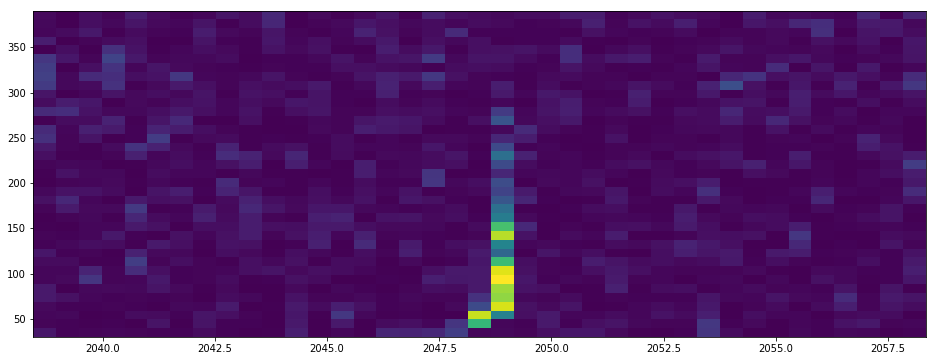

In [4]:
def spectrogram(x, y, windowtype, dxspec, ymin, ymax):
    """create a 2D spectrogram from time-series data
    define type of window to be used. dxspec defines f and x resolution"""
    dx = x[1] - x[0]
    neach = int(dxspec*2//dx)
    xstart = int(neach//2)
    xend = len(x) - xstart - 1
    jump = xstart
    nfft = int((xend - xstart)//jump)
    xspec = np.linspace(x[xstart], x[xend], num=nfft)
    yspec = np.fft.rfftfreq(neach, dx)
    z = np.zeros((nfft, len(yspec)), dtype='complex')
    window = windowtype(np.arange(neach), neach)
    for i in range(0, nfft):
        asd = np.fft.rfft(y[i*jump:i*jump+neach]*window)*dx
        z[i, :] = asd*np.conj(asd)
    i1 = np.argmax(yspec > ymin)
    i2 = np.argmax(yspec > ymax)
    return xspec, yspec[i1:i2], np.real(z[:, i1:i2])


f1, f2 = 30, 400
t, f, spec = spectrogram(ts, strain, Hann, 0.05, f1, f2)
plt.figure(figsize=(16, 6))
plt.imshow(np.transpose(spec[int(9/0.05):-int(9/0.05), :]),
           cmap='viridis', origin='lower', aspect='auto', extent=[t[0],t[-1],f[0],f[-1]])

Perform a Q transform of the data.

slow_qtransform took 15.3746399879 seconds
fast_qtransform took 3.94280600548 seconds


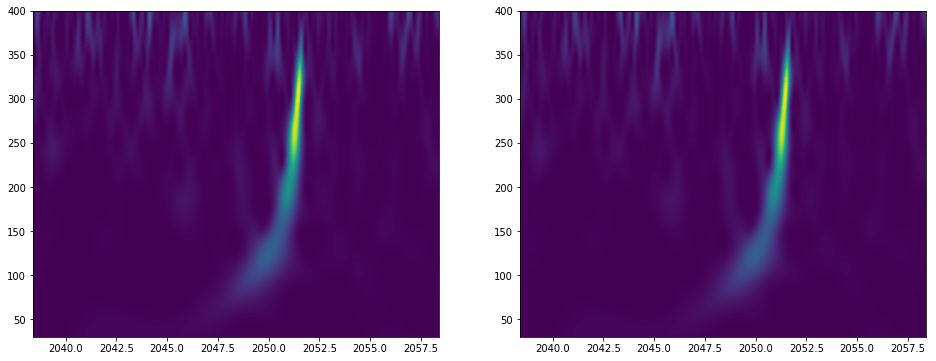

In [51]:
def slow_qtransform(x, y, qval, window, yeval):
    q = np.zeros((len(x), len(yeval)), dtype='complex')
    dx = x[1] - x[0]
    for i in range(0, len(yeval)):
        fi = yeval[i]
        windown = int(qval/(fi*dx))
        windowy = window(np.arange(windown), windown)
        windowy *= 1/np.sum(windowy)
        windowx = np.arange(windown)*dx
        windowyf = windowy * (np.cos(2*np.pi*fi*windowx) - 1j*np.sin(2*np.pi*fi*windowx))
        windowyfi = windowyf*1j
        qpre = np.correlate(y, windowyf, mode='full')
        qprei = np.correlate(y, windowyfi, mode='full')
        cut = int(np.floor(windown/2))
        q[:, i] = (qpre[cut-1+windown%2:-cut]*np.conj(qpre[cut-1+windown%2:-cut]) + 
                   qprei[cut-1+windown%2:-cut]*np.conj(qprei[cut-1+windown%2:-cut]))
    return np.real(q)


def fast_qtransform(x, y, qval, window, yeval):
    q = np.zeros((len(x), len(yeval)), dtype='complex')
    dx = x[1] - x[0]
    num = len(x)
    freqs = np.fft.fftfreq(num, dx)
    yft = np.fft.fft(y) * dx
    for i in range(0, len(yeval)):
        fi = yeval[i]
        shift = int(fi/(freqs[1]-freqs[0]))
        nstart = (num + num%2)/2
        yfti = np.zeros((len(yft)), dtype='complex')
        yfti[0:nstart-shift] += yft[shift:nstart]
        yfti[nstart:-shift] += yft[nstart+shift:]
        yfti[-shift:] += yft[:shift]
        windown = int(qval/(fi*dx)) - int(qval/(fi*dx))%2
        windowy = np.zeros((num), dtype='float')
        windowy[:windown/2] += window(windown/2 + np.arange(windown/2), windown)
        windowy[-windown/2:] += window(np.arange(windown/2), windown)
        windowy *= 1./np.sum(windowy)
        windowft = np.fft.fft(windowy)*dx
        windowfti = 1j*windowft
        qft = np.fft.ifft(yfti*np.conj(windowft))*(freqs[1]-freqs[0])*num
        qfti = np.fft.ifft(yfti*np.conj(windowfti))*(freqs[1]-freqs[0])*num
        q[:, i] = qft*np.conj(qft) + qfti*np.conj(qfti)
    return np.real(q)

f1, f2 = 30, 400
feval = np.geomspace(f1, f2, endpoint=True, num=500)
time0 = time.time()
qslow = slow_qtransform(ts, strain, 5, Hann, feval)
print('slow_qtransform took ' + str(time.time() - time0) + ' seconds')
time0 = time.time()
qfast = fast_qtransform(ts, strain, 5, Hann, feval)
print('fast_qtransform took ' + str(time.time() - time0) + ' seconds')
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(qslow[int(9.7*fs):-int(9.8*fs), :]),
          cmap='viridis', origin='lower', aspect='auto', extent=[ts[0],ts[-1],feval[0],feval[-1]])
plt.subplot(1, 2, 2)
plt.imshow(np.transpose(qfast[int(9.7*fs):-int(9.8*fs), :]),
          cmap='viridis', origin='lower', aspect='auto', extent=[ts[0],ts[-1],feval[0],feval[-1]])